# Introduction

This notebook will illustrate solution of the `lagaris_03` ODE IVP using TensorFlow.

## The `lagaris_03` ODE problem

This ODE was used as the third example problem in (Lagaris et al., 1998). It has been used in several other papers in the neural network/differential equation literature. The differential equation is provided in the form (equation (29) in Lagaris (1998)):

\begin{equation}
    \frac {d^2\psi} {dx^2} + \frac {1} {5} \frac {d \psi} {dx} + \psi = -\frac {1}{5} e^{-x/5} \cos(x)
\end{equation}

or:

\begin{equation}
    G\left(x,\psi,\frac {d\psi}{dx},\frac {d^2\psi} {dx^2}\right) = \frac {d^2\psi} {dx^2} + \frac {1} {5} \frac {d \psi} {dx} + \psi + 
   \frac {1}{5} e^{-x/5} \cos(x) = 0
\end{equation}

with initial conditions:

\begin{equation}
    \psi(0)=0 \\
    \frac {d \psi} {dx} (0) = 1
\end{equation}

The analytical solution is:

\begin{equation}
    \psi_a(x) = e^{-x/5} \sin (x)
\end{equation}

The first derivative is:

\begin{equation}
    \frac {d \psi_a} {dx} = e^{-x/5} \left( \cos(x) - \frac {1} {5} \sin(x) \right)
\end{equation}

The second derivative is:

\begin{equation}
    \frac {d^2 \psi_a} {dx^2} = \frac {1} {5} e^{-x/5} \left(-5 \sin(x) - \cos(x) \right) - \frac {1} {25} e^{-x/5} \left(5 \cos(x) - \sin(x))\right)
\end{equation}

The analytical solution and derivative in the domain $[0,1]$ are plotted below.

In [1]:
# Import standard Python modules.
import datetime
import importlib
import os
import platform
import sys

# Import 3rd-party modules.
import matplotlib.pyplot as plt
import numpy as np

# Import TensorFlow.
import tensorflow as tf

In [2]:
# Use 64-bit math in TensorFlow.
tf.keras.backend.set_floatx('float64')

In [3]:
# Import the problem definition.
eq_name = "lagaris_03_ivp"
eq_module = 'nnde.differentialequation.examples.lagaris_03_ivp'
eq = importlib.import_module(eq_module)

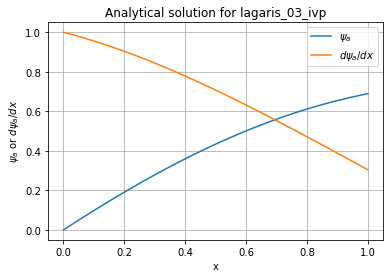

In [4]:
# Compute the analytical solution and derivative.
# Note that Y is used in place of \psi in the code.
nxa = 101
xa = np.linspace(0, 1, nxa)
Ya = [eq.Ya(x) for x in xa]
Ya = np.array(Ya)
dYa_dx = [eq.dYa_dx(x) for x in xa]
dYa_dx = np.array(dYa_dx)

# Plot the analytical solution and derivative.
plt.plot(xa, Ya, label="$\psi_a$")
plt.plot(xa, dYa_dx, label="$d\psi_a/dx$")
plt.xlabel("x")
plt.ylabel("$\psi_a$ or $d\psi_a/dx$")
plt.grid()
plt.legend()
plt.title("Analytical solution for %s" % eq_name)
plt.show()

## Solving `lagaris_03_ivp` using TensorFlow

In [5]:
def print_system_information():
    print("System report:")
    print(datetime.datetime.now())
    print("Host name: %s" % platform.node())
    print("OS: %s" % platform.platform())
    print("uname:", platform.uname())
    print("Python version: %s" % sys.version)
    print("Python build:", platform.python_build())
    print("Python compiler: %s" % platform.python_compiler())
    print("Python implementation: %s" % platform.python_implementation())
    # print("Python file: %s" % __file__)

In [6]:
def create_output_directory(path=None):
    path_noext, ext = os.path.splitext(path)
    output_dir = path_noext
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    return output_dir

In [7]:
from nnde.math.trainingdata import create_training_grid

def create_training_data(nt):
    x_train = np.array(create_training_grid(nt))
    return x_train

In [8]:
def build_model(H, w0_range, u0_range, v0_range):
    hidden_layer = tf.keras.layers.Dense(
        units=H, use_bias=True,
        activation=tf.keras.activations.sigmoid,
        kernel_initializer=tf.keras.initializers.RandomUniform(*w0_range),
        bias_initializer=tf.keras.initializers.RandomUniform(*u0_range)
    )
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.RandomUniform(*v0_range),
        use_bias=False,
    )
    model = tf.keras.Sequential([hidden_layer, output_layer])
    return model

In [9]:
print_system_information()

System report:
2021-12-13 15:10:35.939583
Host name: C02DT5CZMD6T-ML
OS: macOS-10.16-x86_64-i386-64bit
uname: uname_result(system='Darwin', node='C02DT5CZMD6T-ML', release='20.6.0', version='Darwin Kernel Version 20.6.0: Tue Oct 12 18:33:42 PDT 2021; root:xnu-7195.141.8~1/RELEASE_X86_64', machine='x86_64', processor='i386')
Python version: 3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ]
Python build: ('default', 'Oct 12 2021 06:23:56')
Python compiler: Clang 10.0.0 
Python implementation: CPython


In [10]:
# Set up the output directory.
path = os.path.join(".", eq_name)
output_dir = create_output_directory(path)

In [11]:
# Define the hyperparameters.

# Training optimizer
optimizer_name = "Adam"

# Initial parameter ranges
w0_range = [-0.1, 0.1]
u0_range = [-0.1, 0.1]
v0_range = [-0.1, 0.1]

# Maximum number of training epochs.
max_epochs = 20000

# Learning rate.
learning_rate = 0.01

# Absolute tolerance for consecutive loss function values to indicate convergence.
tol = 1e-6

# Number of hidden nodes.
H = 10

# Number of training points.
nx_train = 11
n_train = nx_train

# Number of validation points.
nx_val = 101
n_val = nx_val

# Random number generator seed.
random_seed = 0

In [12]:
# Create and save the training data.
x_train = create_training_data(nx_train)
np.savetxt(os.path.join(output_dir, 'x_train.dat'), x_train)

# Create and save the validation data.
x_val = create_training_data(nx_val)
np.savetxt(os.path.join(output_dir, 'x_val.dat'), x_val)

In [13]:
# Define the differential equation using TensorFlow operations.
@tf.function
def difeq(x, Y, dY_dx, d2Y_dx2):
    G = d2Y_dx2 + 1/5*dY_dx + Y + 1/5*tf.math.exp(-x/5)*tf.math.cos(x)
    return G

In [14]:
# Define the trial function.
@tf.function
def Y_trial(x, N):
    A = x
    P = x**2
    Y = A + P*N
    return Y

In [15]:
# Build the model.
model = build_model(H, w0_range, u0_range, v0_range)

# Create the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Create history variables.
losses = []
phist = []

# Set the random number seed for reproducibility.
tf.random.set_seed(random_seed)

# Rename the training data Variable (_v) for convenience, just for training.
# Reshape to(n_train, 1).
x_train_var = tf.Variable(x_train.reshape((n_train, 1)))
x = x_train_var

# Clear the convergence flag to start.
converged = False

# Train the model.

print("Hyperparameters: n_train = %s, H = %s, max_epochs = %s, optimizer = %s, learning_rate = %s"
      % (n_train, H, max_epochs, optimizer_name, learning_rate))
t_start = datetime.datetime.now()
print("Training started at", t_start)

for epoch in range(max_epochs):

    # Run the forward pass.
    with tf.GradientTape() as tape3:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape1:

                # Compute the network output.
                N = model(x)

                # Compute the trial solution.
                Y = Y_trial(x, N)

            # Compute the gradient of trial solution wrt inputs.
            dY_dx = tape1.gradient(Y, x)

        # Compute the 2nd-order derivative wrt inputs.
        d2Y_dx2 = tape2.gradient(dY_dx, x)

        # Compute the estimates of the differential equation.
        # shape (n_train, 1)
        G = difeq(x, Y, dY_dx, d2Y_dx2)

        # Compute the loss function.
        # shape ()
        L = tf.math.sqrt(tf.reduce_sum(G**2)/n_train)

    # Save the current loss.
    losses.append(L.numpy())

    # Check for convergence.
    if epoch > 0:
        loss_delta = losses[-1] - losses[-2]
        if abs(loss_delta) <= tol:
            converged = True
            break

    # Compute the gradient of the loss function wrt the network parameters.
    # shape [(1, H), (H,), (H, 1)]
    pgrad = tape3.gradient(L, model.trainable_variables)

    # Save the parameters used in this pass.
    phist.append(
        np.hstack(
            (model.trainable_variables[0][0].numpy().reshape((H,)),    # w (1, H) matrix
             model.trainable_variables[1].numpy(),       # u (H,) row vector
             model.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
        )
    )

    # Update the parameters for this pass.
    optimizer.apply_gradients(zip(pgrad, model.trainable_variables))

    if epoch % 100 == 0:
        print("Ending epoch %s, loss function = %s" % (epoch, L.numpy()))

# Save the parameters used in the last epoch.
phist.append(
    np.hstack(
    (model.trainable_variables[0].numpy().reshape((H,)),    # w (1, H) matrix
     model.trainable_variables[1].numpy(),       # u (H,) row vector
     model.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
    )
)

n_epochs = epoch + 1

t_stop = datetime.datetime.now()
print("Training stopped at", t_stop)
t_elapsed = t_stop - t_start
print("Total training time was %s seconds." % t_elapsed.total_seconds())
print("Epochs: %d" % n_epochs)
print("Final value of loss function: %f" % losses[-1])
print("converged = %s" % converged)

Hyperparameters: n_train = 11, H = 10, max_epochs = 20000, optimizer = Adam, learning_rate = 0.01
Training started at 2021-12-13 15:10:35.986762


2021-12-13 15:10:35.983088: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-13 15:10:36.093758: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Ending epoch 0, loss function = 1.1898748741215661
Training stopped at 2021-12-13 15:10:37.499584
Total training time was 1.512822 seconds.
Epochs: 101
Final value of loss function: 0.038322
converged = True


In [16]:
# Compute and save the trained results at training points.
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape1:
        N = model(x)
        Yt_train = Y_trial(x, N)
    dYt_dx_train = tape1.gradient(Yt_train, x)
d2Yt_dx2_train = tape2.gradient(dYt_dx_train, x)
np.savetxt(os.path.join(output_dir, 'Yt_train.dat'), Yt_train.numpy().reshape((nx_train)))
np.savetxt(os.path.join(output_dir, 'dYt_dx_train.dat'), dYt_dx_train.numpy().reshape((nx_train)))
np.savetxt(os.path.join(output_dir, 'd2Yt_dx2_train.dat'), d2Yt_dx2_train.numpy().reshape((nx_train)))

# Compute and save the analytical solution and derivatives at training points.
Ya_train = np.array([eq.Ya(x) for x in x_train])
dYa_dx_train = np.array([eq.dYa_dx(x) for x in x_train])
d2Ya_dx2_train = np.array([eq.d2Ya_dx2(x) for x in x_train])
np.savetxt(os.path.join(output_dir,'Ya_train.dat'), Ya_train)
np.savetxt(os.path.join(output_dir,'dYa_dx_train.dat'), dYa_dx_train)
np.savetxt(os.path.join(output_dir,'d2Ya_dx2_train.dat'), d2Ya_dx2_train)

# Compute and save the error in the trained solution and derivative at training points.
Yt_err_train = Yt_train.numpy().reshape((nx_train)) - Ya_train
dYt_dx_err_train = dYt_dx_train.numpy().reshape((nx_train)) - dYa_dx_train
d2Yt_dx2_err_train = d2Yt_dx2_train.numpy().reshape((nx_train)) - d2Ya_dx2_train
np.savetxt(os.path.join(output_dir, 'Yt_err_train.dat'), Yt_err_train)
np.savetxt(os.path.join(output_dir, 'dYt_dx_err_train.dat'), dYt_dx_err_train)
np.savetxt(os.path.join(output_dir, 'd2Yt_dx2_err_train.dat'), d2Yt_dx2_err_train)

# Compute the final RMS errors.
Yt_rmse_train = np.sqrt(np.sum(Yt_err_train**2)/n_train)
print("Yt_rmse_train = %s" % Yt_rmse_train)

Yt_rmse_train = 0.0032680394934883196


In [17]:
# Compute and save the trained results at validation points.
x_val_var = tf.Variable(x_val.reshape((n_val, 1)))
x = x_val_var
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape1:
        N = model(x)
        Yt_val = Y_trial(x, N)
    dYt_dx_val = tape1.gradient(Yt_val, x)
d2Yt_dx2_val = tape2.gradient(dYt_dx_val, x)
np.savetxt(os.path.join(output_dir, 'Yt_val.dat'), Yt_val.numpy().reshape((nx_val)))
np.savetxt(os.path.join(output_dir, 'dYt_dx_val.dat'), dYt_dx_val.numpy().reshape((nx_val)))
np.savetxt(os.path.join(output_dir, 'd2Yt_dx2_val.dat'), d2Yt_dx2_val.numpy().reshape((nx_val)))

# Compute and save the analytical solution and derivatives at validation points.
Ya_val = np.array([eq.Ya(x) for x in x_val])
dYa_dx_val = np.array([eq.dYa_dx(x) for x in x_val])
d2Ya_dx2_val = np.array([eq.d2Ya_dx2(x) for x in x_val])
np.savetxt(os.path.join(output_dir,'Ya_val.dat'), Ya_val)
np.savetxt(os.path.join(output_dir,'dYa_dx_val.dat'), dYa_dx_val)
np.savetxt(os.path.join(output_dir,'d2Ya_dx2_val.dat'), d2Ya_dx2_val)

# Compute and save the error in the trained solution and derivative at validation points.
Yt_err_val = Yt_val.numpy().reshape((nx_val)) - Ya_val
dYt_dx_err_val = dYt_dx_val.numpy().reshape((nx_val)) - dYa_dx_val
d2Yt_dx2_err_val = d2Yt_dx2_val.numpy().reshape((nx_val)) - d2Ya_dx2_val
np.savetxt(os.path.join(output_dir, 'Yt_err_val.dat'), Yt_err_val)
np.savetxt(os.path.join(output_dir, 'dYt_dx_err_val.dat'), dYt_dx_err_val)
np.savetxt(os.path.join(output_dir, 'd2Yt_dx2_err_val.dat'), d2Yt_dx2_err_val)

# Compute the final RMS errors.
Yt_rmse_val = np.sqrt(np.sum(Yt_err_val**2)/n_val)
print("Yt_rmse_val = %s" % Yt_rmse_val)

Yt_rmse_val = 0.003030283475889947


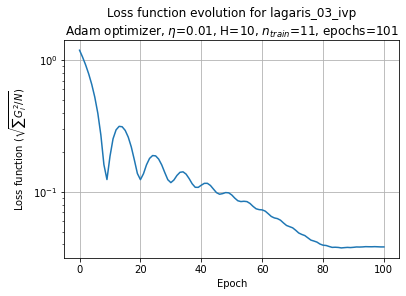

In [18]:
# Plot the loss function history.
plt.semilogy(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sqrt {\sum G_i^2/N}$)")
plt.grid()
plt.title("Loss function evolution for %s\n%s optimizer, $\eta$=%s, H=%s, $n_{train}$=%s, epochs=%s" %
          (eq_name, optimizer_name, learning_rate, H, n_train, n_epochs))
plt.show()

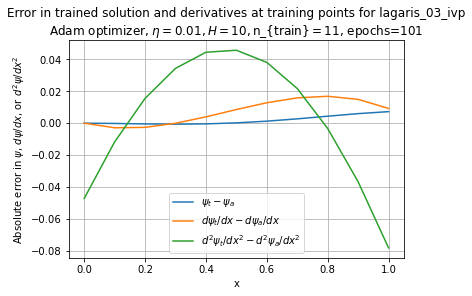

In [19]:
# Plot the errors in the trained solution and derivatives at the training points.
plt.plot(x_train, Yt_err_train, label="$\psi_t - \psi_a$")
plt.plot(x_train, dYt_dx_err_train, label="$d\psi_t/dx - d\psi_a/dx$")
plt.plot(x_train, d2Yt_dx2_err_train, label="$d^2\psi_t/dx^2 - d^2\psi_a/dx^2$")
plt.xlabel("x")
plt.ylabel("Absolute error in $\psi$, $d\psi/dx$, or $d^2\psi/dx^2$")
plt.grid()
plt.legend()
plt.title("Error in trained solution and derivatives at training points for %s\n%s optimizer, $\eta=%s, H=%s, $n_{train}$=%s$, epochs=%s" %
          (eq_name, optimizer_name, learning_rate, H, n_train, n_epochs))
plt.show()

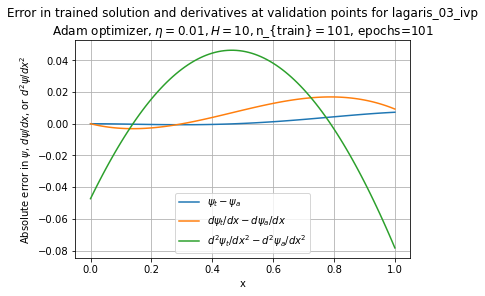

In [20]:
# Plot the errors in the trained solution and derivatives at the validation points.
plt.plot(x_val, Yt_err_val, label="$\psi_t - \psi_a$")
plt.plot(x_val, dYt_dx_err_val, label="$d\psi_t/dx - d\psi_a/dx$")
plt.plot(x_val, d2Yt_dx2_err_val, label="$d^2\psi_t/dx^2 - d^2\psi_a/dx^2$")
plt.xlabel("x")
plt.ylabel("Absolute error in $\psi$, $d\psi/dx$, or $d^2\psi/dx^2$")
plt.grid()
plt.legend()
plt.title("Error in trained solution and derivatives at validation points for %s\n%s optimizer, $\eta=%s, H=%s, $n_{train}$=%s$, epochs=%s" %
          (eq_name, optimizer_name, learning_rate, H, n_val, n_epochs))
plt.show()

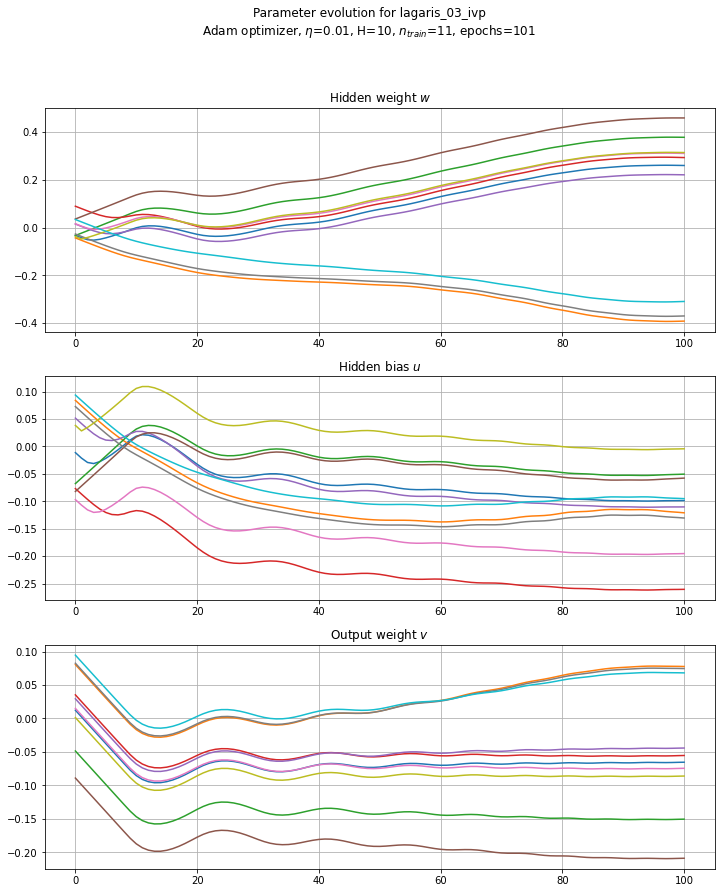

In [21]:
# Plot the parameter histories.
phist = np.array(phist)
plt.figure(figsize=(12, 14))

# w
plt.subplot(311)
plt.plot(phist[:, 0:H])
plt.title("Hidden weight $w$")
plt.grid()

# u
plt.subplot(312)
plt.plot(phist[:, H:2*H])
plt.title("Hidden bias $u$")
plt.grid()

# v
plt.subplot(313)
plt.plot(phist[:, 2*H:3*H])
plt.title("Output weight $v$")
plt.grid()

plt.suptitle("Parameter evolution for %s\n%s optimizer, $\eta$=%s, H=%s, $n_{train}$=%s, epochs=%s" %
          (eq_name, optimizer_name, learning_rate, H, n_train, epoch + 1))
plt.subplots_adjust(hspace=0.2)
plt.show()